In [1]:
DEBUG = True
MODEL_DEBUG = True

### References

<img src="https://www.testdriller.com/pictures/blog/57043786ab6fa09.jpg" width=700/>

## CIFAR100 Classification

> Can we develop a model that performs well on the benchmark dataset CIFAR100?

### Context

The CIFAR-100 dataset (Canadian Institute for Advanced Research) is a subset of the Tiny Images dataset and consists of <strong>60000</strong> <code>32x32</code> colour images in <strong>100</strong> classes, with <strong>600</strong> images per class. The <strong>100</strong> classes in the CIFAR-100 are <strong>grouped into 20 superclasses</strong>. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). There are <strong>50000 training images</strong> and <strong>10000 test images.</strong>

Credit: <a href="https://www.kaggle.com/datasets/fedesoriano/cifar100?select=meta">Kaggle Link</a>

### Objectives

<ol>
	<li>To explore and understand the CIFAR100 dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performanceo f the model</li>
	<li>Discover new techniques and approaches as to tackle the <strong>3 color-channels (RGB) nature</strong> of the dataset.</li>
	<li>Develop and experiment with models in order to rival state-of-the-art (SOTA) benchmark scores.</li>
</ol>

## Importing Libraries
We import the necessary libraries for the notebook to run below.

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import math

import seaborn as sns
sns.set('notebook')

import random
import torch
import torch.nn as nn
import os

We see the seed such that the notebook results in reproducible results when run.   
We also set the device to CUDA to enable torch to use our GPU.

In [3]:
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
# Set a fixed value for the hash seed
os.environ['PYTHONHASHSEED'] = str(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)
if device != torch.device('cuda'):
    print('using cpu, exiting')
    assert False

Device available now: cuda


## Utility Functions
Below we define some utility functions that will ease and help us with our analysis.

In [4]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list = None, grayscale=True, figsize=None):
	if label == None:
		label = [''] * len(arr)

	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	if figsize == None:
		fig = plt.figure()
	else:
		fig = plt.figure(figsize=figsize)
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			ax.imshow(arr[i * height + j], cmap='gray' if grayscale else '')
			ax.set_title(label[i * height + j])

def df_to_tensor(df, shape = (28, 28)):
	return torch.tensor(df.values.reshape((-1, *shape)), dtype=torch.float32)

def preprocess(df):
	return df.applymap(lambda x: x / 255)

def mse(t1, t2, shape=(28, 28)):
	loss = nn.MSELoss(reduction='none')
	loss_result = torch.sum(loss(t1, t2), dim=2)
	loss_result = torch.sum(loss_result, dim=2)
	loss_result = loss_result / np.prod([*shape])
	return loss_result

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the original Fashion MNIST dataset found at <a href="https://arxiv.org/pdf/1708.07747v2.pdf">Paper Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 1 to 100<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 3072
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255. Each image has a dimension of <code>32x32x3</code>.
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
1-5 -> beaver, dolphin, otter, seal, whale
6-10 -> aquarium fish, flatfish, ray, shark, trout
11-15 -> orchids, poppies, roses, sunflowers, tulips
16-20 -> bottles, bowls, cans, cups, plates
21-25 -> apples, mushrooms, oranges, pears, sweet peppers
26-30 -> clock, computer keyboard, lamp, telephone, television
31-35 -> bed, chair, couch, table, wardrobe
36-40 -> bee, beetle, butterfly, caterpillar, cockroach
41-45 -> bear, leopard, lion, tiger, wolf
46-50 -> bridge, castle, house, road, skyscraper
51-55 -> cloud, forest, mountain, plain, sea
56-60 -> camel, cattle, chimpanzee, elephant, kangaroo
61-65 -> fox, porcupine, possum, raccoon, skunk
66-70 -> crab, lobster, snail, spider, worm
71-75 -> baby, boy, girl, man, woman
76-80 -> crocodile, dinosaur, lizard, snake, turtle
81-85 -> hamster, mouse, rabbit, shrew, squirrel
86-90 -> maple, oak, palm, pine, willow
91-95 -> bicycle, bus, motorcycle, pickup truck, train
96-100 -> lawn-mower, rocket, streetcar, tank, tractor
```

Below, we refer to the code provided by the official Kaggle link to extract and load the data from the files in the <code>data</code> folder.

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = 'data/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

data_pre_path = 'data/'

# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
X_train = pd.DataFrame(data_train_dict[b'data'])
y_train = pd.DataFrame(np.array(data_train_dict[b'fine_labels']))
y_train_coarse = pd.DataFrame(np.array(data_train_dict[b'coarse_labels']))
X_test = np.array(data_test_dict[b'data']).flatten()
y_test = np.array(data_test_dict[b'fine_labels']).flatten()
y_test_coarse = pd.DataFrame(np.array(data_test_dict[b'coarse_labels']))

classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'fine_label_names'])))
coarse_classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'coarse_label_names'])))

Let's take a look at the training dataset

In [6]:
X_train.shape

(50000, 3072)

We observe that there are a total of <code>50000</code> rows and <code>3072</code> columns, with each of the columns representing <strong>a single pixel</strong>.

### Testing for missing values and invalid ata
Let's try to identify if there are any missing values

In [7]:
print("Feature missing values:",pd.DataFrame(X_train).isnull().sum().sum())
print("Label missing values:",pd.DataFrame(y_train).isnull().sum().sum())

Feature missing values: 0
Label missing values: 0


### Preprocessing
We perform some transformations such that the channels and dimensions are in the correct format.

In [8]:
temp = np.transpose(X_train.values.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_train = pd.DataFrame(temp.reshape(-1, 3072))

temp = np.transpose(X_test.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_test = pd.DataFrame(temp.reshape(-1, 3072))

Additionally, we will divide every value in the dataset by 255.

In [9]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

## Exploratory Data Analysis
In this EDA we'll be attempting to complete the following set of objectives:

### EDA Objectives
<ol>
	<li>Is there any <strong>class imbalance</strong></li>
	<li>What does the <strong>average image</strong> look like?</li>
	<li>Are there <strong>any outlier/anomalies?</strong>
</ol>

Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to the following reasons:
<ul>
	<li>Time taken to train models, especially if utilising <strong>computationally expensive layers, activation functions or architecture</strong></li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

Let's first <strong>take a look at the size of the test dataset</strong>. The shape of the test dataset will be used to <strong>determine the size of the validation set.</strong>

In [10]:
X_test.shape

(10000, 3072)

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset. We'll also stratify on the <code>label</code> to ensure that the model we generalizes best across all 
the classes.

### Signs of class imbalance?
We'll first identify the siutation with class imbalance

<AxesSubplot: ylabel='Count'>

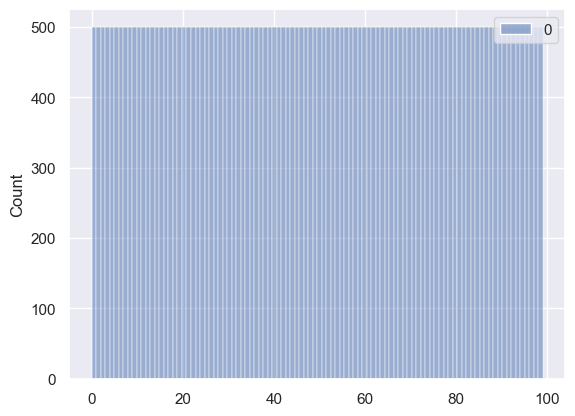

In [11]:
sns.histplot(y_train, bins=100)

We observe the distribution of labels to be similar for all classes, reaching roughly a count of `5000`. Thus, there is no sign of class imbalance.

### What does the average image look like?
Let's take a look at a random sample of images.

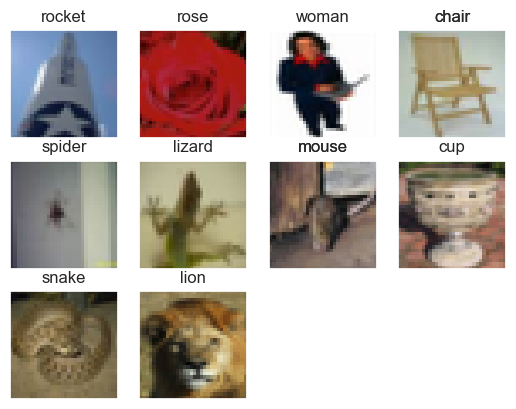

In [12]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train.loc[idx].values.reshape((32, 32, 3)))
	titles.append(classes[y_train.loc[idx].values[0][0]])

imshow(images, titles)

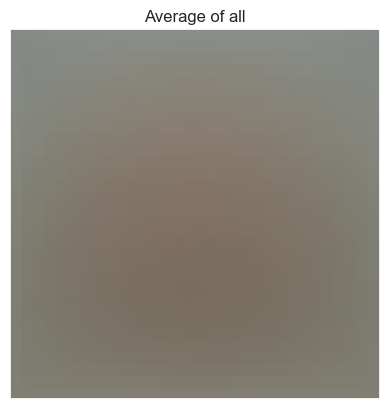

In [13]:
imshow([
	X_train.mean().apply(lambda x: x).values.reshape(32, 32, 3)
], ['Average of all'])

#### Average image among the classes
Next we'll split by the classes and find the average among them.

However, <strong>as our prediction will involve 100 outputs</strong>, what we'll do instead is use the <code>coarse classes</code>, which has 20 classes.

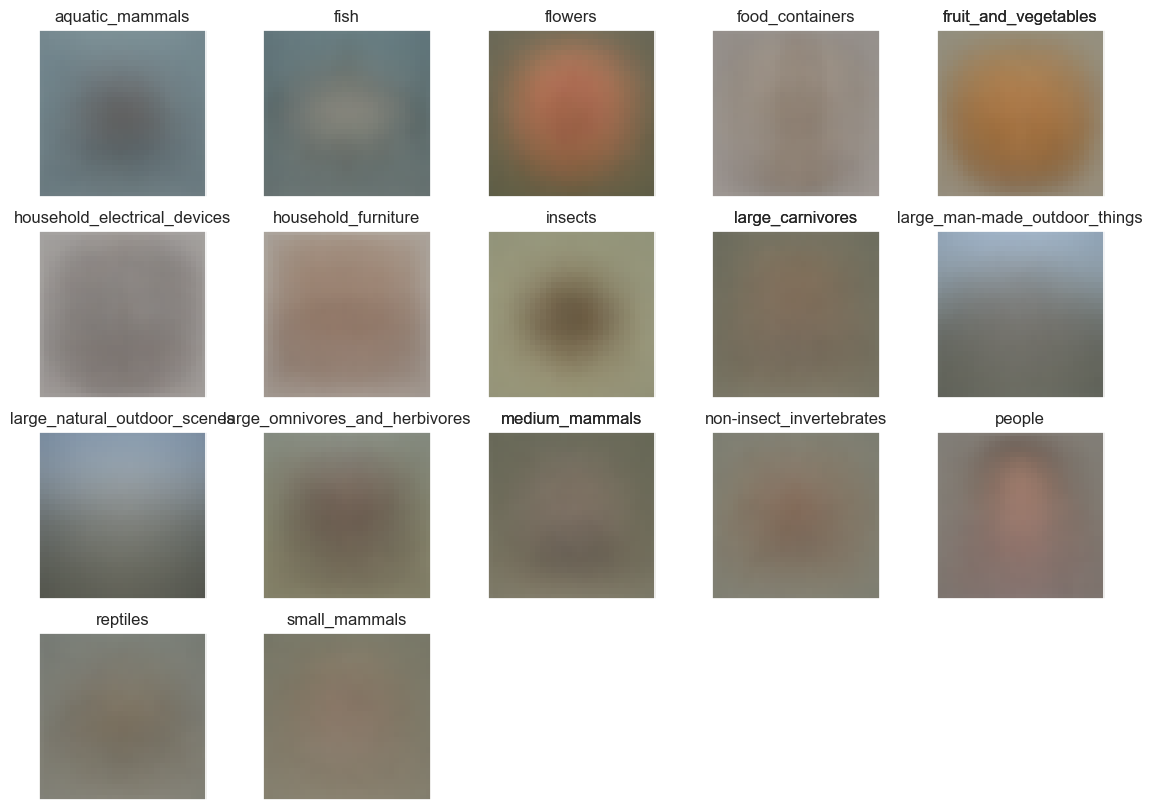

In [54]:
images = []
titles = []

for i in range(20):
	idx = np.where((y_train_coarse.values == i))[0].flatten()
	images.append(X_train.loc[idx].values.reshape(-1, 32, 32, 3).mean(axis=0))
	titles.append(coarse_classes[i])

imshow(images, titles, figsize = (14, 10))

We observe:
<ul>
	<li>We can <strong>barely make out</strong> the figures for classes such as <code>insects</code>, <code>large_carnivore</code>
</ul>that we can barely make out the shapes of the coarse classes.

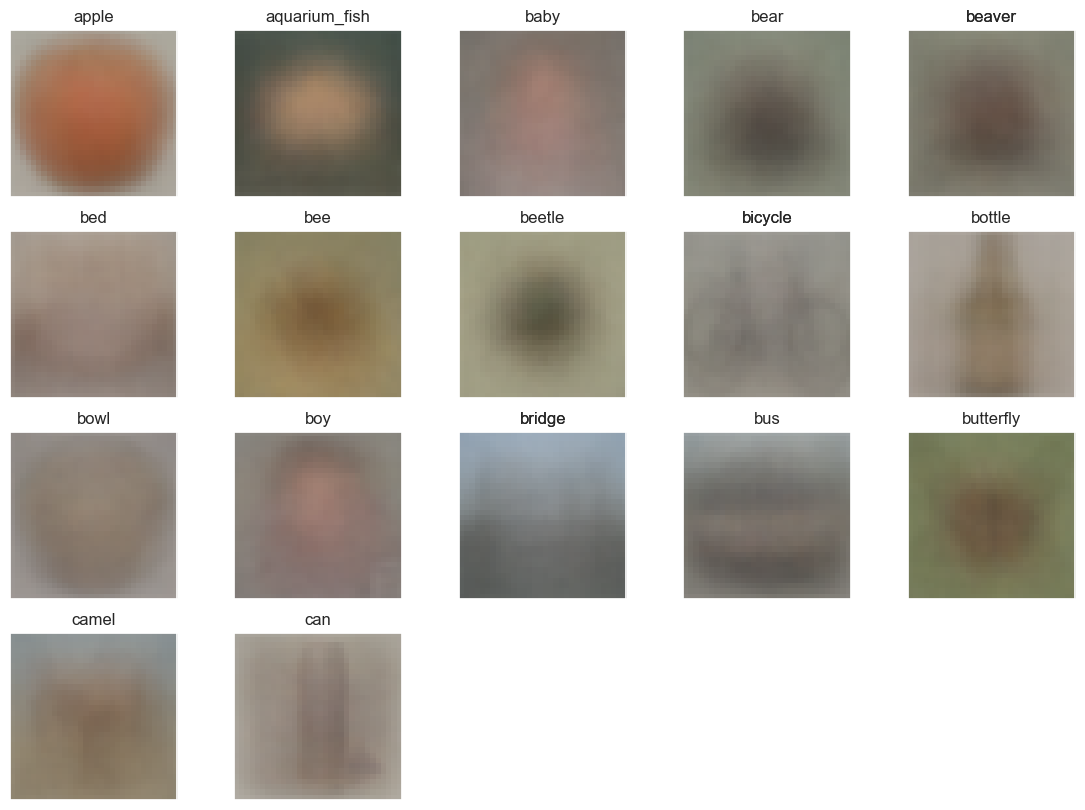

In [53]:
images = []
titles = []

for i in range(20):
	idx = np.where((y_train == i))[0].flatten()
	images.append(X_train.loc[idx].values.reshape(-1, 32, 32, 3).mean(axis=0))
	titles.append(classes[i])

imshow(images, titles, figsize = (14, 10))

In [ ]:
images = []
titles = []

for i in range(20):
	idx = np.where((y_train_coarse.values == i))[0].flatten()
	images.append(X_train.loc[idx].values.reshape(-1, 32, 32, 3).mean(axis=0))
	titles.append(coarse_classes[i])

imshow(images, titles, figsize = (14, 10))